# Thư viện sử dụng

In [82]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Đọc dữ liệu

In [ ]:
# Đọc dữ liệu
file_path = "data.csv"  
df = pd.read_csv(file_path)

# Chuyển đổi cột 'time' thành datetime
df['date'] = pd.to_datetime(df['time'], unit='s')
df = df.sort_values('date')  # Sắp xếp theo thời gian

In [ ]:
# Tổng hợp dữ liệu theo ngày
daily_requests = df.groupby(df['date'].dt.date).size().reset_index(name='count')
daily_requests.rename(columns={'date': 'date'}, inplace=True)

In [ ]:
# Chuyển cột 'date' thành datetime và đặt làm index
daily_requests['date'] = pd.to_datetime(daily_requests['date'])
daily_requests.set_index('date', inplace=True)

# Kiểm tra tính liên tục và bổ sung tần suất
daily_requests = daily_requests.asfreq('D')  # Đặt tần suất hàng ngày
daily_requests['count'] = daily_requests['count'].fillna(0)  # Điền giá trị thiếu bằng 0


In [86]:
daily_requests['day_of_week'] = daily_requests.index.dayofweek
daily_requests['month'] = daily_requests.index.month


# MÔ HÌNH ARIMA

In [ ]:
# Tìm tham số ARIMA tốt nhất
auto_model = auto_arima(daily_requests['count'], seasonal=False, trace=True)
print("Optimal ARIMA Order:", auto_model.order)

# Fit mô hình ARIMA
p, d, q = auto_model.order
model = ARIMA(daily_requests['count'], order=(p, d, q))
model_fit = model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1427.123, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1548.751, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1431.851, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1508.141, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1425.621, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1496.930, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1433.517, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1427.080, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1494.712, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1435.779, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1425.324, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1422.098, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1431.712, Time=0.14 sec
 ARIMA(3,0,4)(0,0,0)[0]             : 

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


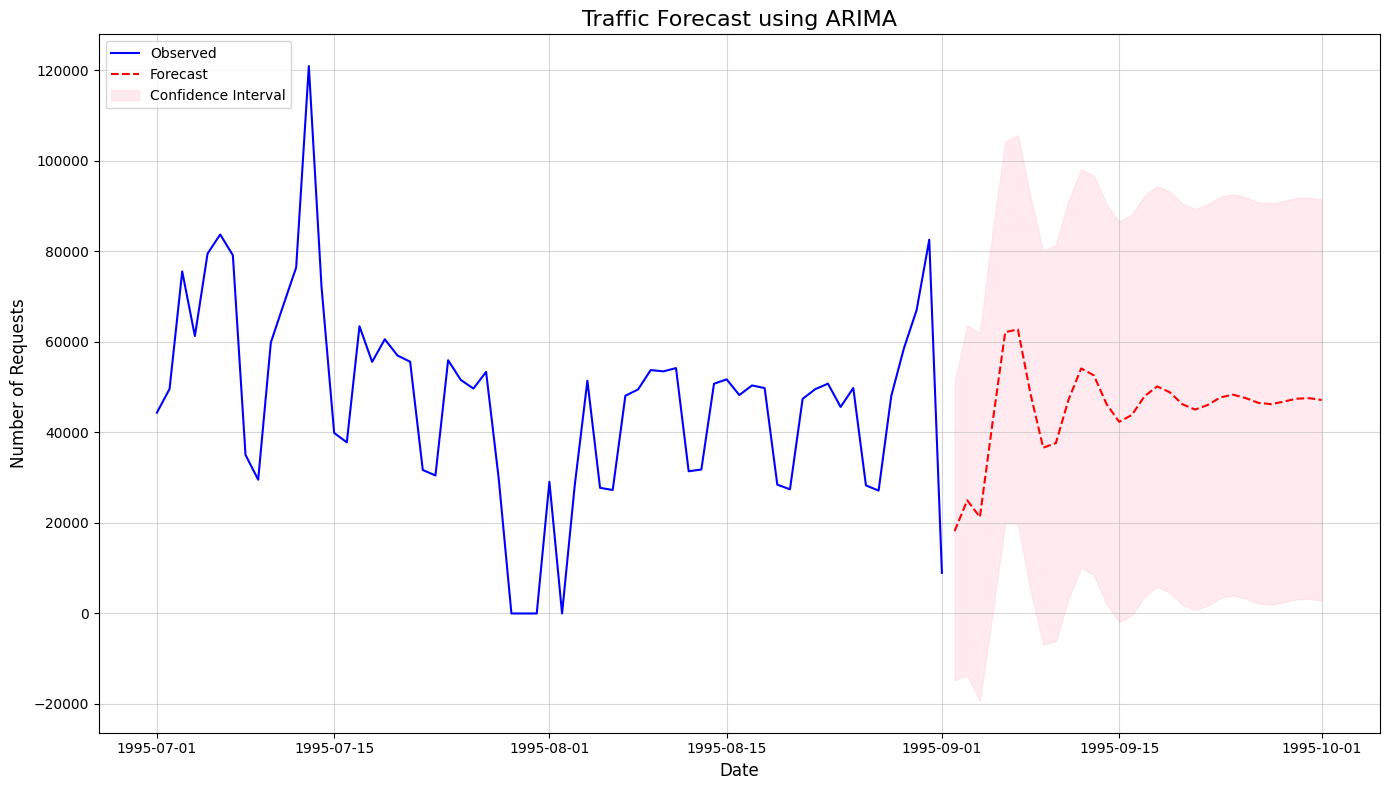

         date      forecast      lower_ci       upper_ci
0  1995-09-02  18178.594887 -14713.487399   51070.677172
1  1995-09-03  25013.479363 -13683.590459   63710.549185
2  1995-09-04  21298.878963 -19337.323248   61935.081175
3  1995-09-05  42186.646933     24.493746   84348.800121
4  1995-09-06  62172.788274  20015.949618  104329.626931
5  1995-09-07  62772.364819  19828.973209  105715.756429
6  1995-09-08  48501.459312   5046.069669   91956.848954
7  1995-09-09  36629.191046  -6829.869913   80088.252004
8  1995-09-10  37653.552553  -6149.718127   81456.823234
9  1995-09-11  47236.603827   3263.506713   91209.700942
10 1995-09-12  54155.728045  10173.194762   98138.261329
11 1995-09-13  52624.323806   8493.576697   96755.070915
12 1995-09-14  46290.969218   2105.973725   90475.964710
13 1995-09-15  42348.801575  -1845.269528   86542.872678
14 1995-09-16  43865.965023   -390.457658   88122.387703
15 1995-09-17  47990.695885   3717.886823   92263.504947
16 1995-09-18  50174.461202   5

In [ ]:
# Dự đoán 30 ngày tiếp theo
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=daily_requests.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Trực quan hóa dữ liệu
plt.figure(figsize=(14, 8))

# Dữ liệu quan sát
plt.plot(daily_requests.index, daily_requests['count'], label='Observed', color='blue')

# Dự báo
plt.plot(forecast_index, forecast_values, label='Forecast', color='red', linestyle='--')

# Vùng tin cậy (Confidence Interval)
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

# Cài đặt biểu đồ
plt.title('Traffic Forecast using ARIMA', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

# In dự báo dưới dạng DataFrame
forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecast': forecast_values,
    'lower_ci': forecast_ci.iloc[:, 0],
    'upper_ci': forecast_ci.iloc[:, 1]
}).reset_index(drop=True)

print(forecast_df.head(30))

# MÔ HÌNH XGBOOST

In [89]:
daily_requests = df.groupby(df['date'].dt.date).agg({
    'bytes': 'sum',  # Tổng bytes theo ngày
    'response': 'count'  # Số lượng request theo ngày
}).reset_index()
daily_requests.rename(columns={'date': 'date', 'response': 'count'}, inplace=True)

XGBoost Evaluation with Improved Parameters:
Mean Absolute Error (MAE): 7520.602701822917
Root Mean Squared Error (RMSE): 13926.790449976048


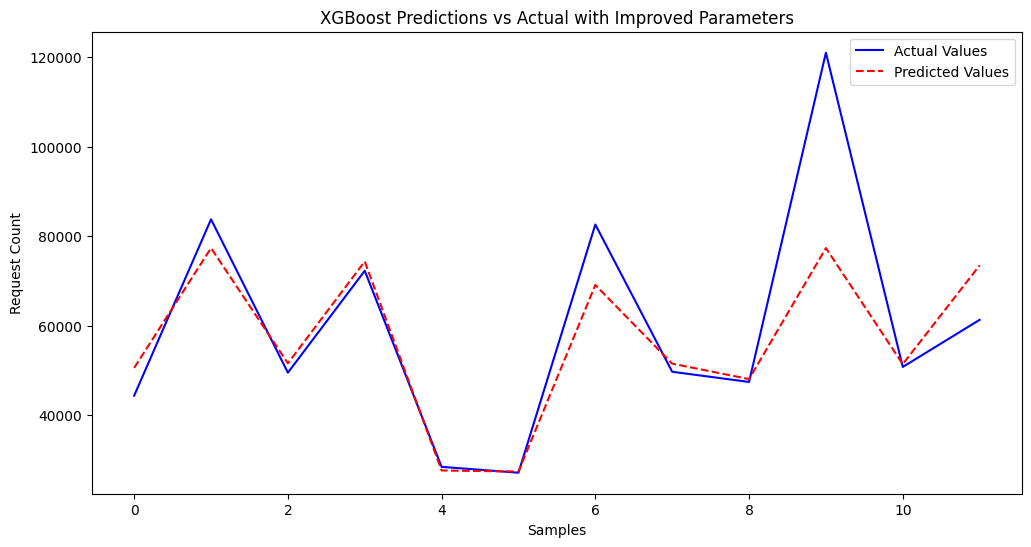

In [ ]:
# Thêm đặc trưng ngày, tháng, giờ và cuối tuần
daily_requests['day_of_week'] = pd.to_datetime(daily_requests['date']).dt.dayofweek
daily_requests['month'] = pd.to_datetime(daily_requests['date']).dt.month
daily_requests['is_weekend'] = daily_requests['day_of_week'].isin([5, 6]).astype(int)

# Chuẩn bị dữ liệu cho mô hình
X = daily_requests[['bytes', 'day_of_week', 'month', 'is_weekend']]  # Các đặc trưng đầu vào
y = daily_requests['count']  # Biến mục tiêu

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình XGBoost với tham số cải thiện
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Đánh giá XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

# In kết quả đánh giá
print("XGBoost Evaluation with Improved Parameters:")
print(f"Mean Absolute Error (MAE): {xgb_mae}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse}")

# Biểu đồ so sánh kết quả dự đoán và thực tế
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Values", color="blue")
plt.plot(xgb_predictions, label="Predicted Values", color="red", linestyle="--")
plt.legend()
plt.title("XGBoost Predictions vs Actual with Improved Parameters")
plt.xlabel("Samples")
plt.ylabel("Request Count")
plt.show()